# Training an RNN to predict the weather at Purdue

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [69]:
data = pd.read_csv("purdue_weather.csv")
# Ensure DATE column is in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

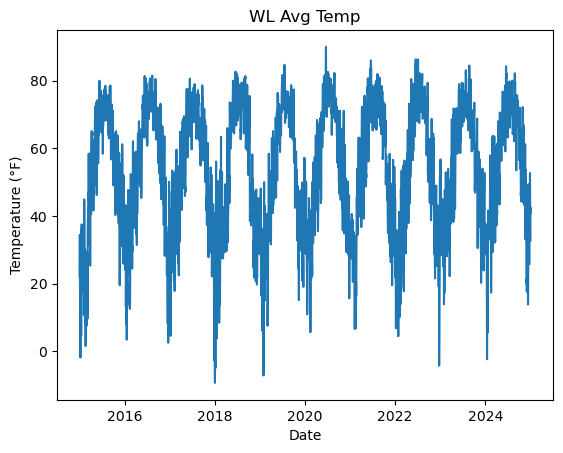

In [70]:
# Plot the TEMP column with DATE on the x-axis
plt.plot(data['DATE'], data['TEMP'])
plt.title('WL Avg Temp')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.show()

## Split Data

In [71]:
# Training loop
train = data[data['DATE'] < '2023-01-01']
test = data[data['DATE'] >= '2023-01-01']

x_train = np.array(train['TEMP'])[:-1]
y_train = np.array(train['TEMP'])[1:]

seq_length = 25


inputs_train = np.array([x_train[i:i+seq_length] for i in range(len(x_train) - seq_length)])
targets_train = np.array([y_train[i:i+seq_length] for i in range(len(y_train) - seq_length)])

## Define the model

In [72]:
# Define model parameters

H = 128 # RNN hidden size
learning_rate = 2e-4 # Learning rate for gradient descent

Wxh = np.random.randn(H, 1) * 0.01 # Input to hidden weights
Whh = np.random.randn(H, H) * 0.01 # Hidden to hidden weights
Why = np.random.randn(1, H) * 0.01 # Hidden to output weights
bh = np.zeros((H, 1)) # Hidden bias
by = np.zeros((1, 1)) # Output bias

## Forward Pass

In [73]:
# Forwarding one example through the RNN

input = inputs_train[0]
target = targets_train[0]

# initialize dictionaries for inputs, hidden states, and outputs in each time step
xs, hs, ys = {}, {}, {}
hs[-1] = np.copy(np.zeros((H, 1)))
loss = 0

# forward pass
for t in range(len(input)):
    xs[t] = input[t].reshape(-1, 1) # (1, 1)
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # (H, 1)
    ys[t] = np.dot(Why, hs[t]) + by # (1, 1)
    loss += (ys[t] - targets_train[t]) ** 2

loss = loss / len(input)

## Backward Pass

In [74]:
# backward pass

# initialize gradients
dWxh = np.zeros_like(Wxh) # (H, 1)
dWhh = np.zeros_like(Whh) # (H, H)
dWhy = np.zeros_like(Why) # (1, H)
dbh = np.zeros_like(bh) # (H, 1)
dby = np.zeros_like(by) # (1, 1)


# backpropagate through time
dhnext = np.zeros_like(hs[0])
for t in reversed(range(len(input))):
    dy = (ys[t] - target[t]) * 2 / len(input) # (1, 1)
    dWhy += np.dot(dy, hs[t].T) # (1, H)
    dby += dy # (1, 1)
    dh = np.dot(Why.T, dy) + dhnext # (H, 1)
    d_hpreact = (1 - hs[t] ** 2) * dh # (H, 1)
    dbh += d_hpreact # (H, 1)
    dWxh += np.dot(d_hpreact, xs[t].T) # (H, 1)
    dWhh += np.dot(d_hpreact, hs[t-1].T) # (H, H)
    dhnext = np.dot(Whh.T, d_hpreact) # (H, 1)

    

## Putting it together

In [75]:
# Warp it all in a function so we can call it repeatedly for each example and update the parameters

def loss_fn(input, target, h_init):
    xs, hs, ys = {}, {}, {}
    hs[-1] = np.copy(h_init)
    loss = 0

    # forward pass
    for t in range(len(input)):
        xs[t] = input[t].reshape(-1, 1) # (1, 1)
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # (H, 1)
        ys[t] = np.dot(Why, hs[t]) + by # (1, 1)
        loss += (ys[t] - target[t]) ** 2
    loss = loss / len(input)
    # loss += 0.5 * (np.sum(Wxh ** 2) + np.sum(Whh ** 2) + np.sum(Why ** 2)) # L2 regularization
    
    # backward pass
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(input))):
        dy = (ys[t] - target[t]) * 2 / len(input)
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext
        d_hpreact = (1 - hs[t] ** 2) * dh
        dbh += d_hpreact
        dWxh += np.dot(d_hpreact, xs[t].T)
        dWhh += np.dot(d_hpreact, hs[t-1].T)
        dhnext = np.dot(Whh.T, d_hpreact)
    # clip gradients to prevent vanishing/exploding gradients
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)
    return loss, [dWxh, dWhh, dWhy, dbh, dby], ys[len(input)-1]


## Training Loop

In [76]:
# Training loop

for epoch in range(1):
    h_init = np.zeros((H, 1))
    for i in range(len(inputs_train)):
        loss, grads, pred = loss_fn(inputs_train[i], targets_train[i], h_init)
        if i % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
        for param, grad in zip([Wxh, Whh, Why, bh, by], grads):
            param -= learning_rate * grad
    print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: [[654.67566543]]
Epoch 0, Loss: [[1716.0225745]]
Epoch 0, Loss: [[2149.24149556]]
Epoch 0, Loss: [[144.83533715]]
Epoch 0, Loss: [[60.20876137]]
Epoch 0, Loss: [[300.89822909]]
Epoch 0, Loss: [[95.7035628]]
Epoch 0, Loss: [[64.82635059]]
Epoch 0, Loss: [[48.71976411]]
Epoch 0, Loss: [[50.48721166]]
Epoch 0, Loss: [[23.32553397]]
Epoch 0, Loss: [[104.16415036]]
Epoch 0, Loss: [[67.96640632]]
Epoch 0, Loss: [[15.36998259]]
Epoch 0, Loss: [[30.26469606]]
Epoch 0, Loss: [[41.69087946]]
Epoch 0, Loss: [[15.69313712]]
Epoch 0, Loss: [[18.12107792]]
Epoch 0, Loss: [[47.60930303]]
Epoch 0, Loss: [[49.97485381]]
Epoch 0, Loss: [[9.03893028]]
Epoch 0, Loss: [[42.5831432]]
Epoch 0, Loss: [[31.17028544]]
Epoch 0, Loss: [[36.23532153]]
Epoch 0, Loss: [[9.09691471]]
Epoch 0, Loss: [[60.29670117]]
Epoch 0, Loss: [[66.65618396]]
Epoch 0, Loss: [[23.4561473]]
Epoch 0, Loss: [[27.97143765]]
Epoch 0, Loss: [[76.4247664]]


## Test the model

Average Test Loss: [[178.54727457]]


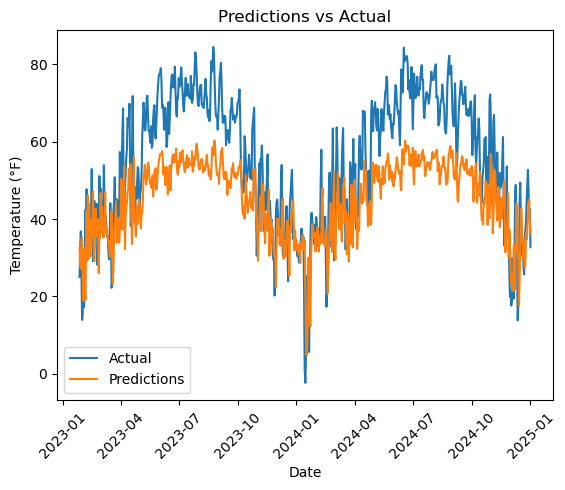

In [77]:
# Test the model

x_test = np.array(test['TEMP'])[:-1]
y_test = np.array(test['TEMP'])[1:]

inputs_test = np.array([x_test[i:i+seq_length] for i in range(len(x_test) - seq_length)])
targets_test = np.array([y_test[i:i+seq_length] for i in range(len(y_test) - seq_length)])

h_init = np.zeros((H, 1))
predictions = []
avg_test_loss = 0
for i in range(len(inputs_test)):
    loss, _, pred = loss_fn(inputs_test[i], targets_test[i], h_init)
    avg_test_loss += loss
    predictions.append(pred[0][0])
avg_test_loss /= len(inputs_test)
# Plot predictions vs actual
plt.plot(test['DATE'][seq_length+1:], y_test[seq_length:], label='Actual')
plt.plot(test['DATE'][seq_length+1:], predictions, label='Predictions')
plt.title('Predictions vs Actual')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Temperature (°F)')
plt.legend()
print(f'Average Test Loss: {avg_test_loss}')

## Add Batch Dimension

Training on one example at a time leads to a noisy approximation of the loss function.


Training is mutch more stable when we average loss over batches of input data.

In [87]:
# add batch dimension to

def loss_fn(input, target, h_init):
    # input shape is (batch_size, seq_length)
    B = input.shape[0]
    T = input.shape[1]
    xs, hs, ys = {}, {}, {}
    hs[-1] = np.tile(h_init, (1, B)) # (H, B)
    loss = 0

    # forward pass
    for t in range(T):
        xs[t] = input[:, t].reshape(1, -1) # (1, B)

        # (H, B) = (H, 1) @ (1, B) + (H, H) @ (H, B) + (H, 1)
        hs[t] = np.tanh(np.matmul(Wxh, xs[t]) + np.matmul(Whh, hs[t-1]) + bh) # (H, B)

        # (1, B) = (1, H) @ (H, B) + (1, 1)
        ys[t] = np.matmul(Why, hs[t]) + by # (1, B)

        # MSE loss
        loss += np.mean((ys[t] - target[:, t].reshape(1, -1)) ** 2)
    loss = loss / T
    
    # backward pass
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(T)):
        dy = 2 * (ys[t] - target[:, t].reshape(1, -1)) / (B * T) # (1, B)
        dWhy += np.matmul(dy, hs[t].T) # (1, H)
        dby += np.sum(dy, axis=1, keepdims=True) # (1, 1)
        dh = np.matmul(Why.T, dy) + dhnext # (H, B)
        d_hpreact = (1 - hs[t] ** 2) * dh # (H, B)
        dbh += np.sum(d_hpreact, axis=1, keepdims=True) # (H, 1)
        dWxh += np.matmul(d_hpreact, xs[t].T) # (H, 1)
        dWhh += np.matmul(d_hpreact, hs[t-1].T) # (H, H)
        dhnext = np.matmul(Whh.T, d_hpreact) # (H, B)

    # clip gradients to prevent vanishing/exploding gradients
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)
    return loss, [dWxh, dWhh, dWhy, dbh, dby], ys[T-1]

# Training loop
batch_size = 32
for epoch in range(5):
    h_init = np.zeros((H, 1))
    # Get batches
    for i in range(0, len(inputs_train), batch_size):
        batch_inputs = inputs_train[i:i+batch_size]
        batch_targets = targets_train[i:i+batch_size]
        
        # Skip incomplete batches
        if len(batch_inputs) < batch_size:
            continue
            
        # Stack batches into arrays
        batch_inputs = np.stack(batch_inputs)
        batch_targets = np.stack(batch_targets)
        
        loss, grads, pred = loss_fn(batch_inputs, batch_targets, h_init)
            
        for param, grad in zip([Wxh, Whh, Why, bh, by], grads):
            param -= learning_rate * grad
            
    print(f'Epoch {epoch}, Final Loss: {loss}')

Epoch 0, Final Loss: 60.18400826523106
Epoch 1, Final Loss: 58.20455484366555
Epoch 2, Final Loss: 56.93392016885056
Epoch 3, Final Loss: 56.01907984105549
Epoch 4, Final Loss: 55.42339214032908


Average Test Loss: 57.894448025633785


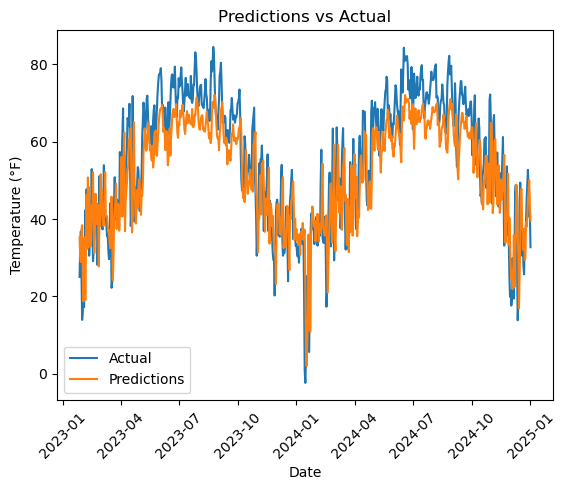

In [86]:
# Test the model

x_test = np.array(test['TEMP'])[:-1]
y_test = np.array(test['TEMP'])[1:]

inputs_test = np.array([x_test[i:i+seq_length] for i in range(len(x_test) - seq_length)])
targets_test = np.array([y_test[i:i+seq_length] for i in range(len(y_test) - seq_length)])

h_init = np.zeros((H, 1))
predictions = []
avg_test_loss = 0
for i in range(len(inputs_test)):
    loss, _, pred = loss_fn(inputs_test[i].reshape(1, -1), targets_test[i].reshape(1, -1), h_init)
    avg_test_loss += loss
    predictions.append(pred[0][0])
avg_test_loss /= len(inputs_test)
# Plot predictions vs actual
plt.plot(test['DATE'][seq_length+1:], y_test[seq_length:], label='Actual')
plt.plot(test['DATE'][seq_length+1:], predictions, label='Predictions')
plt.title('Predictions vs Actual')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Temperature (°F)')
plt.legend()
print(f'Average Test Loss: {avg_test_loss}')

# Now with an LSTM

Epoch 0, Average Loss: 944.9496
Epoch 1, Average Loss: 179.5479
Epoch 2, Average Loss: 57.3229
Epoch 3, Average Loss: 49.6253
Epoch 4, Average Loss: 49.6272
Test Loss: 46.31734276223115


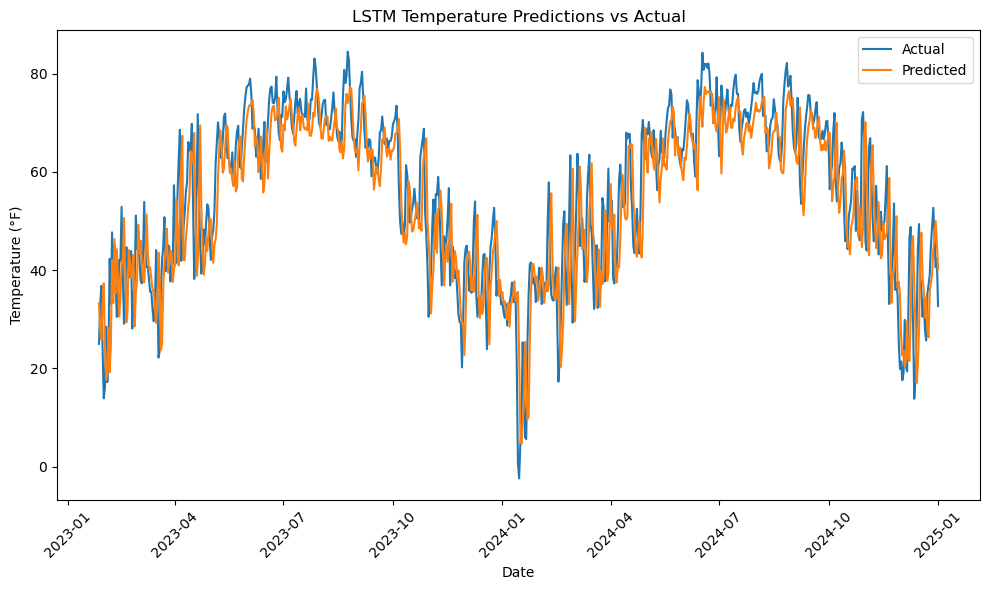

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        out = self.linear(lstm_out)
        return out

# Initialize the model
input_size = 1
hidden_size = 128
output_size = 1
batch_size = 32

model = LSTM(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# convert inputs and targets to tensors
inputs_train_tensor = torch.tensor(inputs_train, dtype=torch.float32).unsqueeze(-1)
targets_train_tensor = torch.tensor(targets_train, dtype=torch.float32).unsqueeze(-1)
inputs_test_tensor = torch.tensor(inputs_test, dtype=torch.float32).unsqueeze(-1)
targets_test_tensor = torch.tensor(targets_test, dtype=torch.float32).unsqueeze(-1)

# Create data loaders
train_dataset = TensorDataset(inputs_train_tensor, targets_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch_inputs, batch_targets in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}')

# Test
model.eval()
test_loss = 0
predictions = []

with torch.no_grad():
    for i in range(len(inputs_test_tensor)):
        output = model(inputs_test_tensor[i])
        predictions.append(output[-1].item())
        loss = criterion(output, targets_test_tensor[i])
        test_loss += loss.item()

avg_test_loss = test_loss / inputs_test_tensor.shape[0]
print(f'Test Loss: {avg_test_loss}')

# Plot predictions vs actual
plt.figure(figsize=(10,6))
plt.plot(test['DATE'][seq_length+1:], y_test[seq_length:], label='Actual')
plt.plot(test['DATE'][seq_length+1:], predictions, label='Predicted')
plt.title('LSTM Temperature Predictions vs Actual')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Temperature (°F)')
plt.legend()
plt.tight_layout()
